# Dimensionality Reduction
## Experimental set up:
Let's pretend I have a robot who is taking images under water for some industrial application OR for whatever reason I want to evaluate pixel response for some unknown imaging system. I recieved a .tiff which is known to be light responsive for red, green, and blue (RGB) colors. In this hypothetical toy example, my domain knowledge tells me that I must generate a single image from the RGB, as my robot's decision making is biased by specific colors.

This scenario is not a stretch considering some experimental imaging systems could have more than 3 colors if extended into other wavelengths (UV or IR): simply reading the image as grayscale would not work if we had more than 3 colors! 
But using our imagination, let's just take this toy example and run with how one could reduce the data and extrapolate to higher dimensions.

In [12]:
from PIL import Image
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

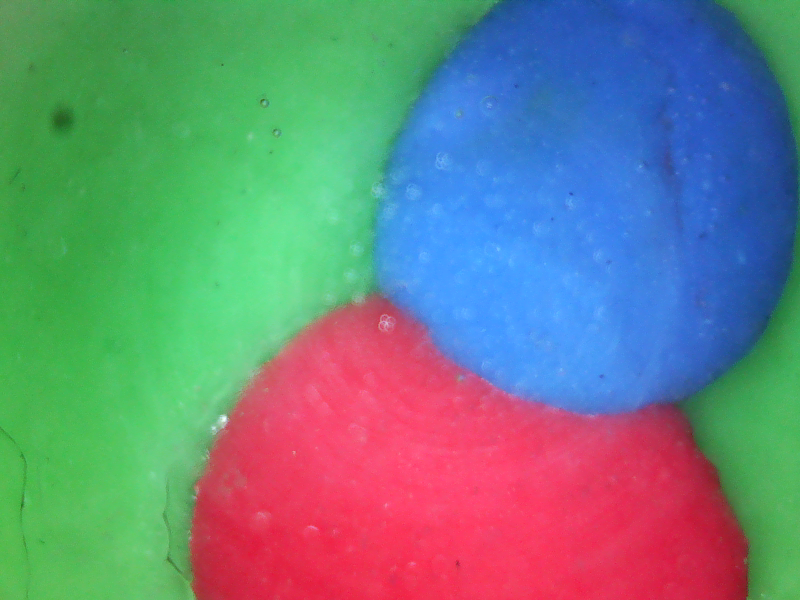

In [13]:
#lets just take a peek at what we are working with, it is a standard .tiff image when displayed with color it looks like this:
imdisp = Image.open('Image08.tiff')
imdisp

## Reading in as a .tiff with openCV shows this file is actually 3 images, a red, green, and blue one. Let's take a look at the individual pixel response images

In [14]:
im = cv.imread('Image08.tiff')
np.shape(im)
#let's note the shape of the image, since it is a .tiff file the first 2 dimensions correspond to pixels in x,y
#while the last dimension corresponds to color

(600, 800, 3)

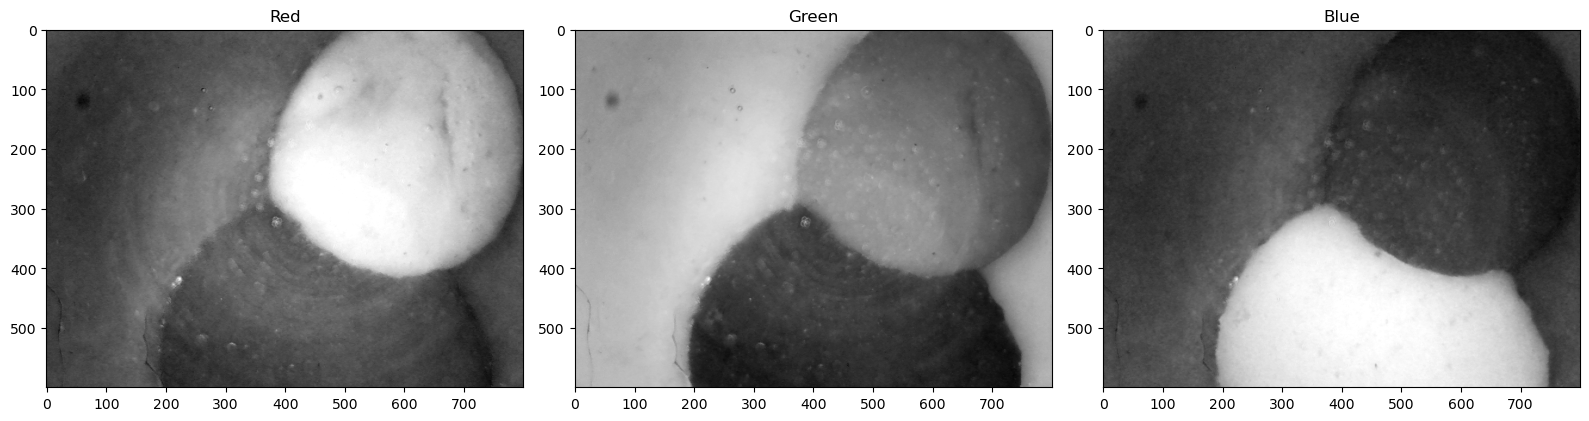

In [15]:
%matplotlib inline
fig,axes = plt.subplots(1,3,figsize=(16,6))

axes[0].imshow(im[:,:,0],cmap='gray')
axes[0].set_title("Red")

axes[1].imshow(im[:,:,1],cmap='gray')
axes[1].set_title("Green")

axes[2].imshow(im[:,:,2],cmap='gray')
axes[2].set_title("Blue");

plt.tight_layout();

The three pixel response (RGB) images are used to make a single color image. A simple weighted average could make a single grayscale image. But again, let's pretend our imaging system could have dozens of pixel response images (more than RGB) and/or the weights are not known specifically for making this grayscale image.

# The Empirical Orthogonal Function
The EOF (Lorenz 1956), was a powerful method for dealing with the shortcomings faced in statistical forecasting of non-linear chaotic systems, such as climate. The engine driving the EOF is Singlular Value Decomposition, which is used in a lot of applications for approximating overdetermined systems or one way to deal with degeneracies of the Hamiltonian in Quantum Mechanics. The math described in Lorenz paper is Jacobi's method for diagonalizing a matrix. The important thing to note for this example, is that it is an orthonomal change of basis for our RGB.

Our feature space: Matrix $A$ has the covariance computed as $Cov(A) = AA^T$
The decomposition, of $AA^T = USV^T$ Where $U$ is the left hand Unitary and $S$ is your diagonal of singular values. We keep $U$ and $U_{proj A} = \frac{A^TU}{||A||_2}$ is the projection back onto itself.

In [16]:
def theEOF(inimage):
    rgb = []
    k = len(inimage[0,0,:])
    rgb = [inimage[:,:,i].ravel() for i in range(k)]
    rgb = rgb - np.mean(rgb)
    cov = (1/k)*(rgb @ np.transpose(rgb))
    U, S, VT = np.linalg.svd(cov)
    eof=[]
    reshaped = []
    for j in range(k):
        t = np.transpose(rgb) @ U[:,j]
        eof.append(t/np.sqrt(sum(t**2)))
        reshaped.append(np.reshape(eof[j][:],(600,800)))
    return reshaped


# Principal Component Analysis
Seen as a completely different algorithm entirely for whatever reason is Principal Component Analysis (PCA). While you can do some other things with PCA, which I will get to in Part 2, the implementation of it below is also an orthonormal change of basis- two different algorithms, doing the same task.

In [25]:
def imagePCA(inimage):
    rgb = []
    target = []
    k = len(inimage[0,0,:])
    rgb = [inimage[:,:,i].ravel() for i in range(k)]
    rgb = rgb - np.mean(rgb)
    cov = (1/k)*(rgb @ np.transpose(rgb))
    w,b = np.linalg.eigh(cov)
    print(100* w/sum(w))
    v = rgb.T @ b

    for i in range(len(w)):
        v[:,i] /= np.sqrt(sum(v[:,i]**2))
    for i in range(len(w)):
        coef = sum(rgb[i,:] * v[:,i])
        target.append(coef * v[:,i])
    target_reshaped = []
    for i in range(len(im[0,0,:])):
        target_reshaped.append(np.reshape(target[i][:],(600,800)))
    target_reshaped = np.array(target_reshaped)
    return target_reshaped

In [26]:
#create the EOF from the RGB, and lets see the results:
reshaped = np.array(theEOF(im))
print(np.shape(reshaped))

(3, 600, 800)


# EOF transformation:
We can see below the output is a complete transformation of the feature space. If our job were to "reduce" the data, we can keep the first image as the EOF and throw the rest out as "junk", effectivey reducing the data from by 2/3

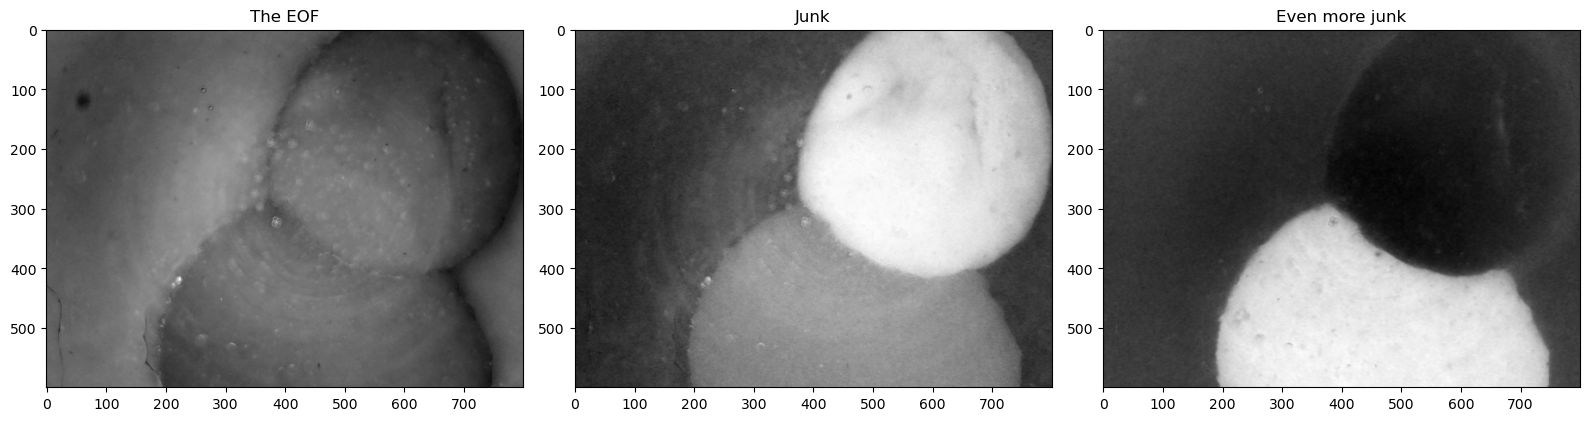

In [27]:
fig,axes = plt.subplots(1,3,figsize=(16,6))

axes[0].imshow(reshaped[2,:,:],cmap='gray')
axes[0].set_title("The EOF")

axes[1].imshow(reshaped[1,:,:],cmap='gray')
axes[1].set_title("Junk")

axes[2].imshow(reshaped[0,:,:],cmap='gray')
axes[2].set_title("Even more junk");

plt.tight_layout();

# Compare EOF with traditional Grayscale Image
Now that we have the EOF, we can see how it compares to reading in a grayscale image. Did it work?

In [28]:
img = cv.imread("Image08.tiff", cv.IMREAD_GRAYSCALE)

Text(0.5, 1.0, 'EOF - Gray (color difference)')

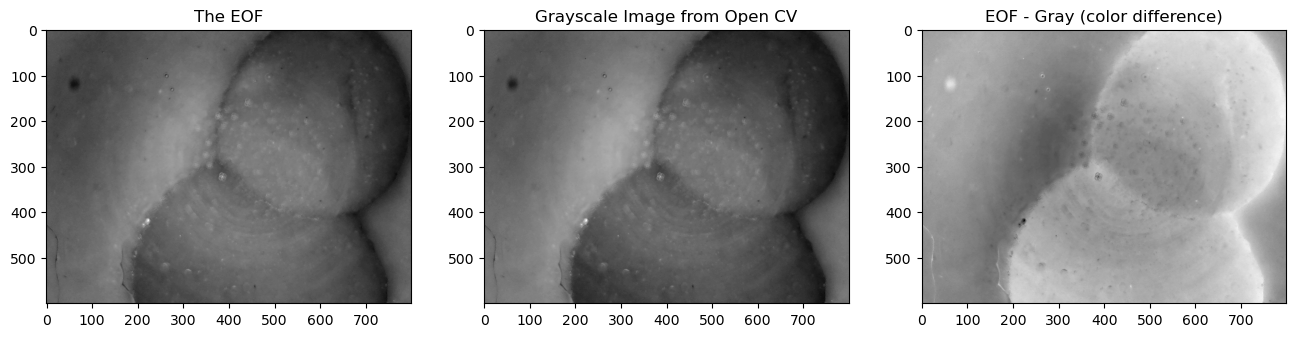

In [29]:
fig,axes = plt.subplots(1,3,figsize=(16,6))

axes[0].imshow(reshaped[2,:,:],cmap='gray')
axes[0].set_title("The EOF")

axes[1].imshow((img),cmap='gray')
axes[1].set_title("Grayscale Image from Open CV")

axes[2].imshow((reshaped[2,:,:] - img),cmap='gray')
axes[2].set_title("EOF - Gray (color difference)")

# Result of EOF
Clearly we can see th similarities between a traditional gayscale image made with OpenCV and the EOF. If we extrapolated this to a higher dimensionality image set, would we be able to trust the grayscale image using the EOF when no traditional methods could be made available?
Clearly by looking at the third (leftmost) image, where we subtracted the EOF and the Grayscale image, no two methods are exact. In making the covariance matrix, the pixel scaling was changed. However, we can also look at the distribution of pixel values. Are the images the same and only scaled differently? Can we trust the EOF?

# Below
We see the distribution of our EOF and then the distribution of OpenCV grayscale respectively.

<AxesSubplot:ylabel='Count'>

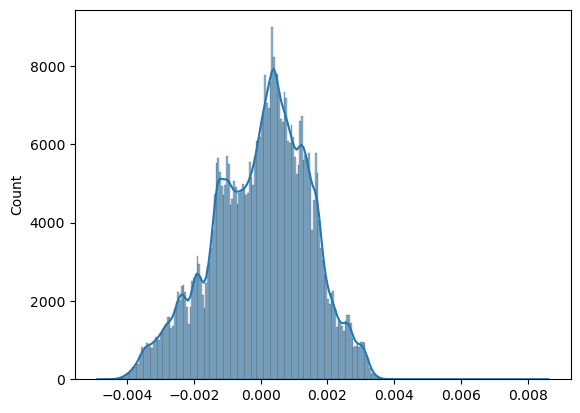

In [30]:
import seaborn as sns
sns.histplot(data=reshaped[2,:,:].ravel(),kde=True)

<AxesSubplot:ylabel='Count'>

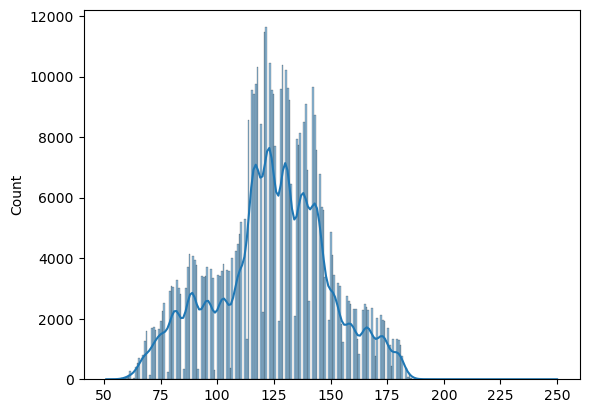

In [31]:
sns.histplot(data=img.ravel(),kde=True)

# PCA transformation:

Let's throw the RGB into our PCA change of basis, and see how it compares to both the EOF and OpenCV grayscale

In [32]:
target_reshaped = np.array(imagePCA(im))
print(np.shape(target_reshaped))

[10.65810558 26.66837203 62.67352239]
(3, 600, 800)


Text(0.5, 1.0, 'PCA3')

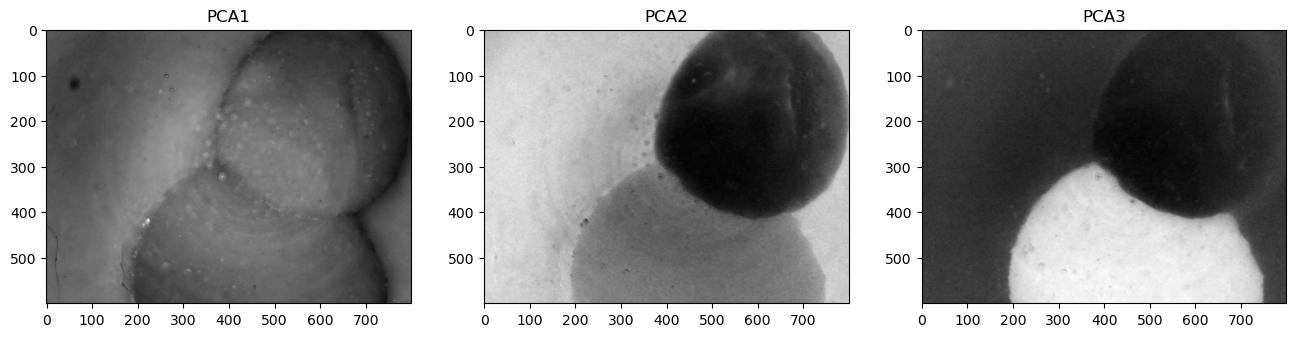

In [33]:
fig,axes = plt.subplots(1,3,figsize=(16,6))

axes[0].imshow((target_reshaped[0,:,:]),cmap='gray')
axes[0].set_title("PCA1")

axes[1].imshow((target_reshaped[1,:,:]),cmap='gray')
axes[1].set_title("PCA2")

axes[2].imshow(target_reshaped[2,:,:],cmap='gray')
axes[2].set_title("PCA3")

# Above:
We can observe the PCA change of basis

# Below:
We can compare PCA, EOF, and OpenCV

Text(0.5, 1.0, 'OpenCV Grayscale Image')

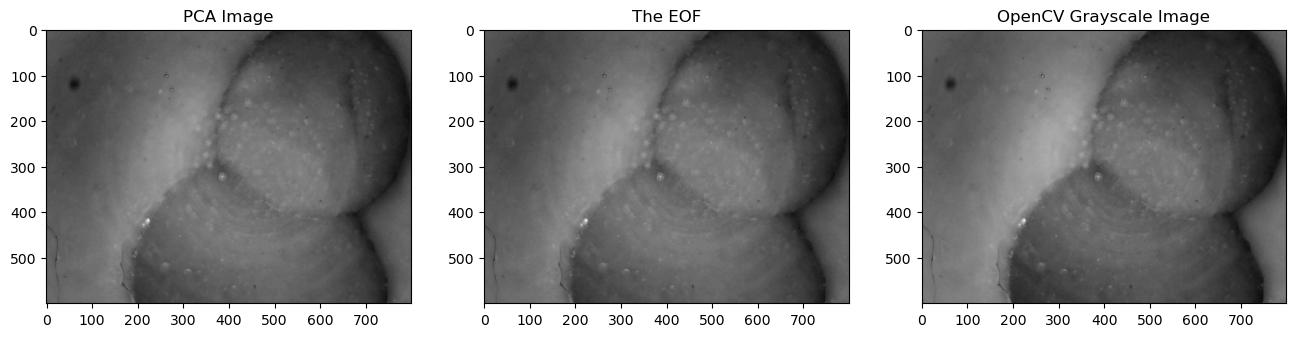

In [36]:
fig,axes = plt.subplots(1,3,figsize=(16,6))

axes[0].imshow((target_reshaped[0,:,:]),cmap='gray')
axes[0].set_title("PCA Image")

axes[1].imshow(reshaped[2,:,:],cmap='gray')
axes[1].set_title("The EOF")

axes[2].imshow(img,cmap='gray')
axes[2].set_title("OpenCV Grayscale Image")

<AxesSubplot:ylabel='Count'>

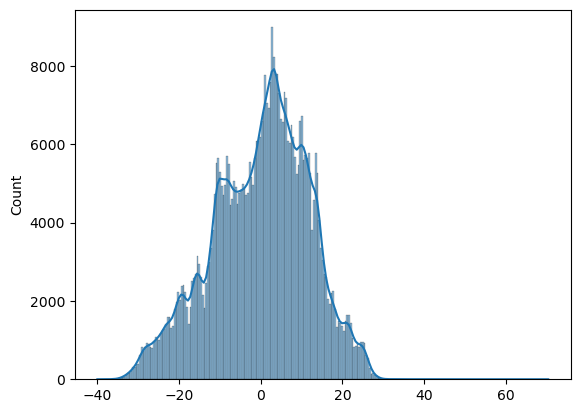

In [111]:
#Pixel distribution for the PCA image:

sns.histplot(data=target_reshaped[0,:,:].ravel(),kde=True)

Therefore PCA, like EOF, is also an orthonormal transformation (change of basis). In this example, we both created a relyable grayscale image and we reduced the data by 2/3. But, as I will show in Part 2, we can also project an entirely new image onto the basis of several different images that have also undergone the same PCA transformation. We can use Percent Variance, $w=s$ to rank the principal components and reconstruct the input image from our library, called Eigenimages.